# Importance Sampling






This is the prior ...

\begin{align*}
p(\theta) = \frac {1} { \sqrt { 2 \pi \sigma^2  } } exp \Big( - \frac 1 {2\sigma^2} \mathbf \theta ^ \top \mathbf \theta  \Big)
\end{align*}

The log of this quantity will give you the log probability of the prior

\begin{align*}
\log (p(\theta)) = -0.5 \log ( 2 \pi \sigma^2 ) -  \frac 1 {2\sigma^2}  || \theta || ^2 _2
\end{align*}

In [4]:
def p_log_theta( sigma, theta):
    '''
    sigma (float): assumes a single sigma for all the theta
    theta (2D array): array containing the values of the sigma
        dim-0: a sample $theta$ vector
        dim-1: an index into the $theta$ vector.
        For an n-dimensional $theta$, the second dimension will be n
    '''
    ss = 2*sigma**2
    logP   = - (theta**2).sum(axis=1) / ss
    logP -= 0.5 * np.log(np.pi * ss )
    
    return logP

The probability of $y$ given $X$ and $\theta$ is given by the following equations:

\begin{align*}
p( \mathbf y | \mathbf X, \mathbf\theta) &= \Pi_i \mathrm {Ber} (y_i | \mathrm {sigm} (x_i, \mathbf \theta) ) \\
         &= \Pi_i \Big[ \frac 1 {1+e^{- \mathbf x_i \mathbf \theta}} \Big]^{y_i} \Big[ 1 - \frac 1 {1+e^{- \mathbf x_i \mathbf \theta}} \Big]^{1 - y_i}
\end{align*}


If we take the logarithm on both sides, we shall see that this expression reduces to the following:

\begin{align*}
\log p( \mathbf y | \mathbf X, \mathbf\theta) &= \log \Pi_i \Big[ \frac 1 {1+e^{- \mathbf x_i \mathbf \theta}} \Big]^{y_i} \Big[ 1 - \frac 1 {1+e^{- \mathbf x_i \mathbf \theta}} \Big]^{1 - y_i} \\
        &= \Sigma_i y_i \log \Big[ \frac 1 {1+e^{- \mathbf x_i \mathbf \theta}} \Big] + (1 - y_i) \log \Big[ 1 - \frac 1 {1+e^{- \mathbf x_i \mathbf \theta}} \Big] 
\end{align*} 

Note that computationally this might lead to instabiliity. Hence, for computational purposes, this is changed using the [following technique](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits):

If we assume that $\mathbf x_i \mathbf \theta = w$, then the -ve expressioon for the $i$<sup>th</sup> data point can be written as:

\begin{align*}
-y_i \log [\pi_i] - (1-y_i) \log [1 - \pi_i] &= -y_i \log [ 1/( 1 + e^{-w} ) ] - (1-y_i) \log [ e^{-w}/( 1 + e^{-w} ] \\
  &= y_i  \log ( 1 + e^{-w} ) - (1-y_i) \log [ e^{-w}] + (1-y_i) \log ( 1 + e^{-w} ) \\
  &= - (1-y_i) \log [ e^{-w}] +  \log ( 1 + e^{-w} ) \\
  &= w (1-y_i) +  \log ( 1 + e^{-w} ) \\
  &= w - w y_i +  \log ( 1 + e^{-w} ) \\
\end{align*}


There is also the probllem when $x<0$. Here, the expression for $e^{-w}$ might overflow. Under these circumstances, the above equation is reformulated such that:

\begin{align*}
  w - w y_i +  \log ( 1 + e^{-w} ) &= \log( e^w ) - w y_i + \log ( 1 + e^{-w} ) \\
   &= - w y_i + \log ( 1 + e^{w} )
\end{align*}

Hence, the two equatons can be combined into the single expression:

\begin{align*}
    \mathrm {max}(w, 0) - w y_i + \log ( 1 + e^{-|w|} )
\end{align*}


Remember that this is the -ve value of the quantity we are seeking. So finally, this will have to be multiplied by $-1$.

Translating that back into the previous expressions,

\begin{align*}
    \mathrm {max}(w, 0) - w y_i + \log ( 1 + e^{-|w|} ) = \mathrm {max}(\mathbf x_i \mathbf \theta) - \mathbf x_i \mathbf \theta y_i + \log ( 1 + e^{-|\mathbf x_i \mathbf \theta|} )
\end{align*}

In [48]:
def p_log_y_given_X_thata(X, y, theta):
    '''
    X: (nd array) (N, d)
    y: (1d array) (N,1)
    theta: (nd array) (t, d)
    
    Here, 
        N = the number of data samples
        t = the number of samples of theta
        d = the dimensionality of the problem
        
    The dimensionality of the problem will determine the shape of both the
    theta as well as X.
    '''
    
    w    = X @ theta.T # W = (N, t)
    result = np.where( w < 0, 0, w ) - w * y + np.log( 1 + np.exp( - np.abs(w)  )  ) # (N, t)
    result = -1 * result # Notice the equations change signs atthe optimization process
    result = result.sum(axis=0) # (t,)
    
    return result

Now, we are going to use Bayes rule to obtain the proabbility of theta, given the data. 

\begin{align*}
p(\mathbf \theta | \mathbf X, \mathbf y) = \frac 1 Z p( \mathbf y | \mathbf X, \mathbf \theta ) p(\mathbf \theta)
\end{align*}

In this equation, the vlaue of $Z$ is given by

\begin{align*}
Z &= \int p(\mathbf y|\mathbf X, \theta) p(\theta) d\theta \\
\end{align*}

Note that the value of $Z$ is typically not easy to calculate, and we shall be calculating that based on two differrent techniques. The first part is importance sampling, and the other one is Marcov Chain Monte Carlo (MCMC) integration. However, before we do the integration, we shall want to explore the logarithmic implementation of the above implementations:

\begin{align*}
\log p(\mathbf \theta | \mathbf X, \mathbf y) &= \log \frac 1 Z p( \mathbf y | \mathbf X, \mathbf \theta ) p(\mathbf \theta) \\
        &= \log \frac 1 Z + \log p( \mathbf y | \mathbf X, \mathbf \theta ) + \log  p(\mathbf \theta) \\
        &= - \log Z + \log p( \mathbf y | \mathbf X, \mathbf \theta ) + \log  p(\mathbf \theta) \\
\end{align*}

The last two parts of the equation are things that we already have functions for. Also remember that since we marginalize over $\theta$ the probability density of $\theta$ only scales equally over all values. 

In [62]:
import numpy as np
import matplotlib.pyplot as plt

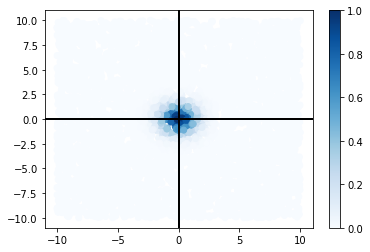

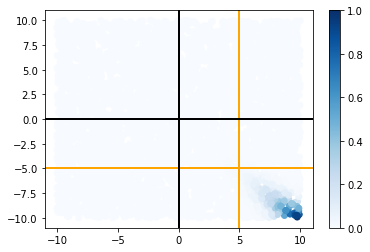

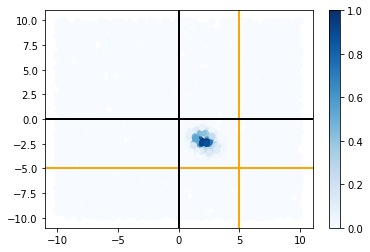

In [101]:
N, d, t = 50, 2, 5000

theta = np.random.uniform(-10, 10, (t, d))

thetaReal = np.array([5, -5]).reshape((1, -1))
X = (np.random.random((N, d)) - 0.5)*2
y = (X @ thetaReal.T).sum(axis=1)
y = np.where( y > 0 , 1  ,  y)
y = np.where( y == 0, 0.5, y)
y = np.where( y < 0 , 0  ,  y)
y = y.reshape((-1, 1))

prob_log_theta = p_log_theta(1, theta)
prob_log_y = p_log_y_given_X_thata(X, y, theta)

prob_theta = np.exp( prob_log_theta )
prob_theta /= prob_theta.max()

prob_y = np.exp( prob_log_y )
prob_y /= prob_y.max()

prob = prob_y * prob_theta
prob /= prob.max()

plt.figure()
plt.scatter( theta[:, 0], theta[:, 1], c=prob_theta,  cmap=plt.cm.Blues)
plt.axhline( 0, color='black', lw=2)
plt.axvline( 0, color='black', lw=2)
plt.colorbar()

plt.figure()
plt.scatter( theta[:, 0], theta[:, 1], c=prob_y, cmap=plt.cm.Blues)
plt.axhline(-5, color='orange', lw=2)
plt.axvline( 5, color='orange', lw=2)
plt.axhline( 0, color='black', lw=2)
plt.axvline( 0, color='black', lw=2)
plt.colorbar()

plt.figure()
plt.scatter( theta[:, 0], theta[:, 1], c= prob ,  cmap=plt.cm.Blues)
plt.axhline(-5, color='orange', lw=2)
plt.axvline( 5, color='orange', lw=2)
plt.axhline( 0, color='black', lw=2)
plt.axvline( 0, color='black', lw=2)
plt.colorbar()

plt.show()
plt.close('all')


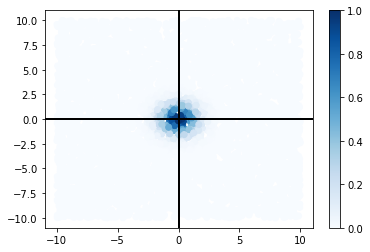

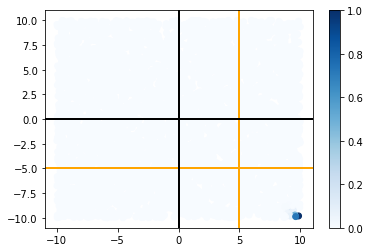

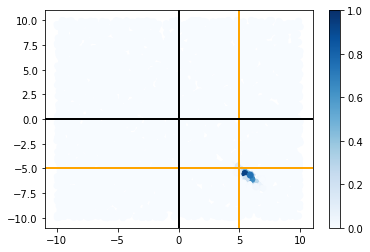

In [106]:
N, d, t = 500, 2, 5000

theta = np.random.uniform(-10, 10, (t, d))

thetaReal = np.array([5, -5]).reshape((1, -1))
X = (np.random.random((N, d)) - 0.5)*2
y = (X @ thetaReal.T).sum(axis=1)
y = np.where( y > 0 , 1  ,  y)
y = np.where( y == 0, 0.5, y)
y = np.where( y < 0 , 0  ,  y)
y = y.reshape((-1, 1))

prob_log_theta = p_log_theta(1, theta)
prob_log_y = p_log_y_given_X_thata(X, y, theta)

prob_theta = np.exp( prob_log_theta )
prob_theta /= prob_theta.max()

prob_y = np.exp( prob_log_y )
prob_y /= prob_y.max()

prob = prob_y * prob_theta
prob /= prob.max()

plt.figure()
plt.scatter( theta[:, 0], theta[:, 1], c=prob_theta,  cmap=plt.cm.Blues)
plt.axhline( 0, color='black', lw=2)
plt.axvline( 0, color='black', lw=2)
plt.colorbar()

plt.figure()
plt.scatter( theta[:, 0], theta[:, 1], c=prob_y, cmap=plt.cm.Blues)
plt.axhline(-5, color='orange', lw=2)
plt.axvline( 5, color='orange', lw=2)
plt.axhline( 0, color='black', lw=2)
plt.axvline( 0, color='black', lw=2)
plt.colorbar()

plt.figure()
plt.scatter( theta[:, 0], theta[:, 1], c= prob ,  cmap=plt.cm.Blues)
plt.axhline(-5, color='orange', lw=2)
plt.axvline( 5, color='orange', lw=2)
plt.axhline( 0, color='black', lw=2)
plt.axvline( 0, color='black', lw=2)
plt.colorbar()

plt.show()
plt.close('all')

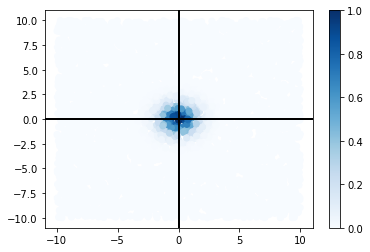

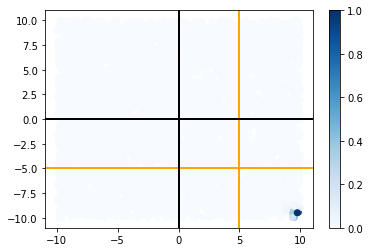

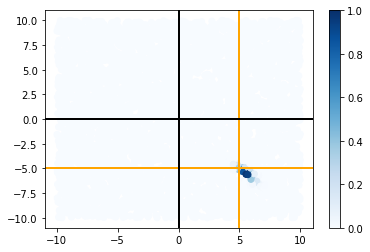

In [107]:
, d, t = 5000, 2, 5000

theta = np.random.uniform(-10, 10, (t, d))

thetaReal = np.array([5, -5]).reshape((1, -1))
X = (np.random.random((N, d)) - 0.5)*2
y = (X @ thetaReal.T).sum(axis=1)
y = np.where( y > 0 , 1  ,  y)
y = np.where( y == 0, 0.5, y)
y = np.where( y < 0 , 0  ,  y)
y = y.reshape((-1, 1))

prob_log_theta = p_log_theta(1, theta)
prob_log_y = p_log_y_given_X_thata(X, y, theta)

prob_theta = np.exp( prob_log_theta )
prob_theta /= prob_theta.max()

prob_y = np.exp( prob_log_y )
prob_y /= prob_y.max()

prob = prob_y * prob_theta
prob /= prob.max()

plt.figure()
plt.scatter( theta[:, 0], theta[:, 1], c=prob_theta,  cmap=plt.cm.Blues)
plt.axhline( 0, color='black', lw=2)
plt.axvline( 0, color='black', lw=2)
plt.colorbar()

plt.figure()
plt.scatter( theta[:, 0], theta[:, 1], c=prob_y, cmap=plt.cm.Blues)
plt.axhline(-5, color='orange', lw=2)
plt.axvline( 5, color='orange', lw=2)
plt.axhline( 0, color='black', lw=2)
plt.axvline( 0, color='black', lw=2)
plt.colorbar()

plt.figure()
plt.scatter( theta[:, 0], theta[:, 1], c= prob ,  cmap=plt.cm.Blues)
plt.axhline(-5, color='orange', lw=2)
plt.axvline( 5, color='orange', lw=2)
plt.axhline( 0, color='black', lw=2)
plt.axvline( 0, color='black', lw=2)
plt.colorbar()

plt.show()
plt.close('all')